In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# Set a random seed for reproducibility
torch.manual_seed(42)

In [2]:
from differential_model import *
from generate_data import *
from physical_model import *
from plot import *

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")


No GPU available, using CPU.


In [5]:
# Define parameters for the structural dynamics problem
ndof = 5  # Number of degrees of freedom
kvec = [95, 98, 100, 104, 97]
cvec = [0.18, 0.22, 0.24, 0.18, 0.19]
mvec = [1, 1, 1, 0.8, 0.8]

# Create an assembly matrix 'onemat'
onemat = np.array([[1, -1], [-1, 1]])

# Initialize the assembly matrix for each degree of freedom
assembly_mat = [np.zeros((ndof, ndof)) for _ in range(ndof)]
assembly_mat[0][0, 0] = 1

# Initialize Mass, Stiffness, and Damping matrices
Mass = np.diag(mvec)
Stif = np.zeros((ndof, ndof))
Damp = np.zeros((ndof, ndof))

# Assemble Stiffness and Damping matrices
for i in range(ndof):
    if i != 0:
        assembly_mat[i] = np.zeros((ndof, ndof))
        assembly_mat[i][i-1:i+1, i-1:i+1] = onemat
    Stif += kvec[i] * assembly_mat[i]
    Damp += cvec[i] * assembly_mat[i]

# Now, 'Stif' and 'Damp' matrices are assembled based on the assembly_mat and provided parameters

fs = 50
Tf = 10
tspan = torch.arange(0, Tf, 1/fs)
nt = fs * Tf

In [6]:
# Initialize the Spring_Model on the GPU
spring_model_gt = NonLinearDynamicsModel(Mass, Stif, Damp, fs, device, k3vec = [10000, 0, 0, 5000, 0], c2vec = [0, 0, 0, 0, 0])
simulator = LinearDynamicsModel(Mass, Stif, Damp, fs, device)

Current State: 1
A Shape: torch.Size([10, 10])
B Shape: torch.Size([10, 5])
A_k3 Shape: torch.Size([10, 10])
A_c2 Shape: torch.Size([10, 10])


In [7]:
sig_u = [1, 3, 5]
data_gt = torch.zeros(nt, len(sig_u), 10)
data_simulated = torch.zeros(nt, len(sig_u), 10)
u_data = torch.zeros(nt, len(sig_u), 5)

for i in range(len(sig_u)):
    u = generate_u(sig_u[i], nt, fs, device)
    u_vec = torch.zeros(nt, 5).to(device)
    u_vec[:, 0] = u
    data_gt[:, i, :] = generate_date(spring_model_gt, u_vec).T
    data_simulated[:, i, :] = generate_date(simulator, u_vec).T
    u_data[:, i, :] = u_vec


In [8]:
initial_error = torch.mean((data_gt -data_simulated) ** 2)
initial_error

tensor(0.0312)

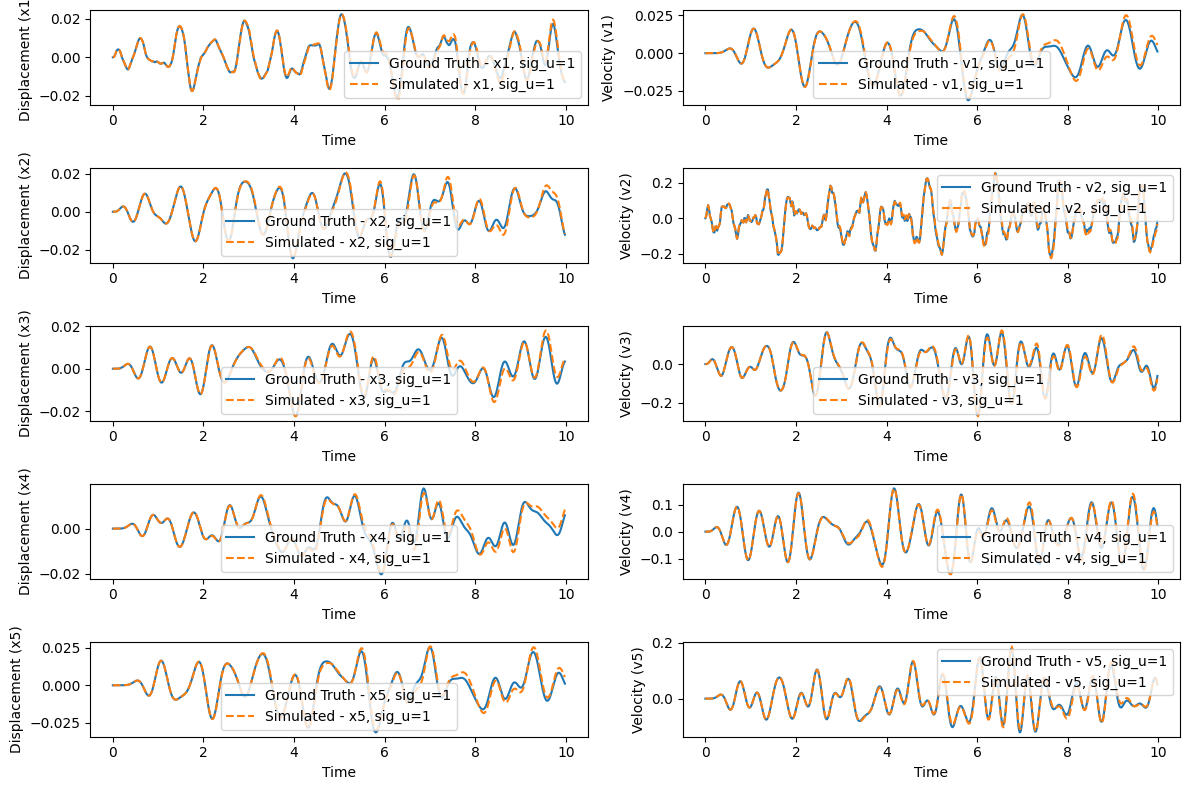

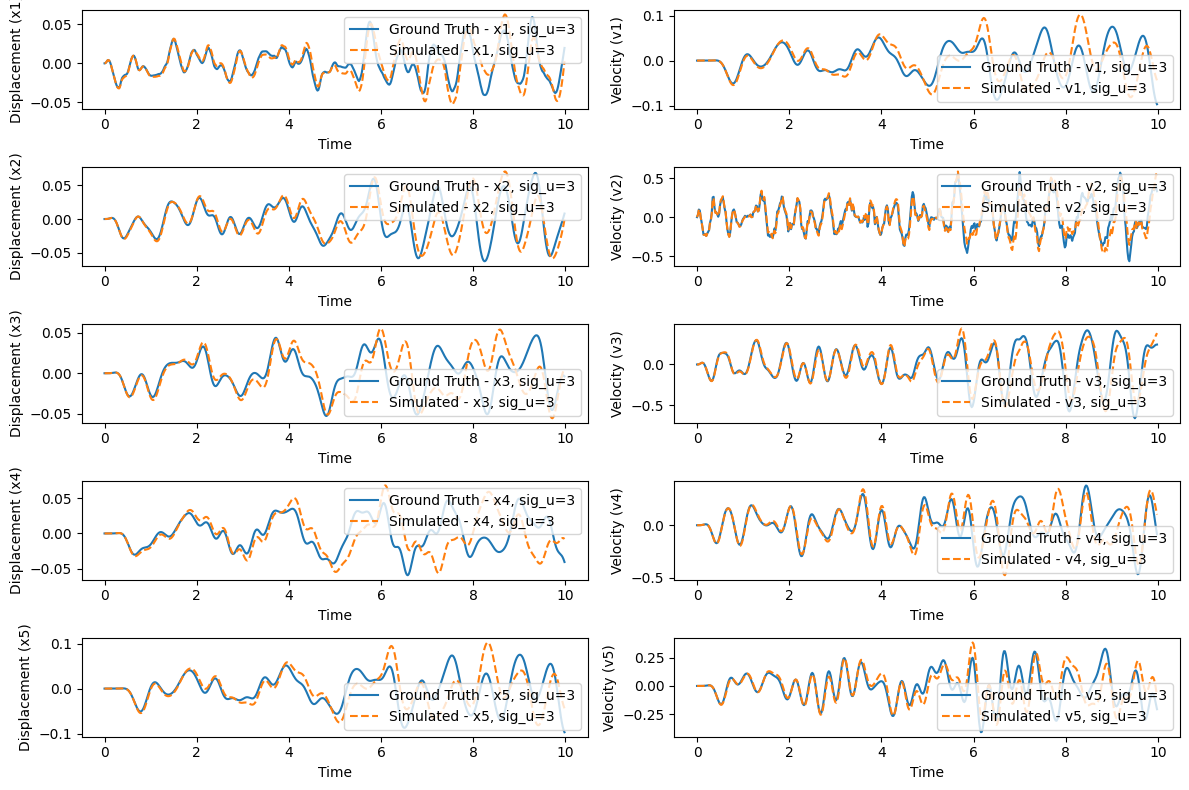

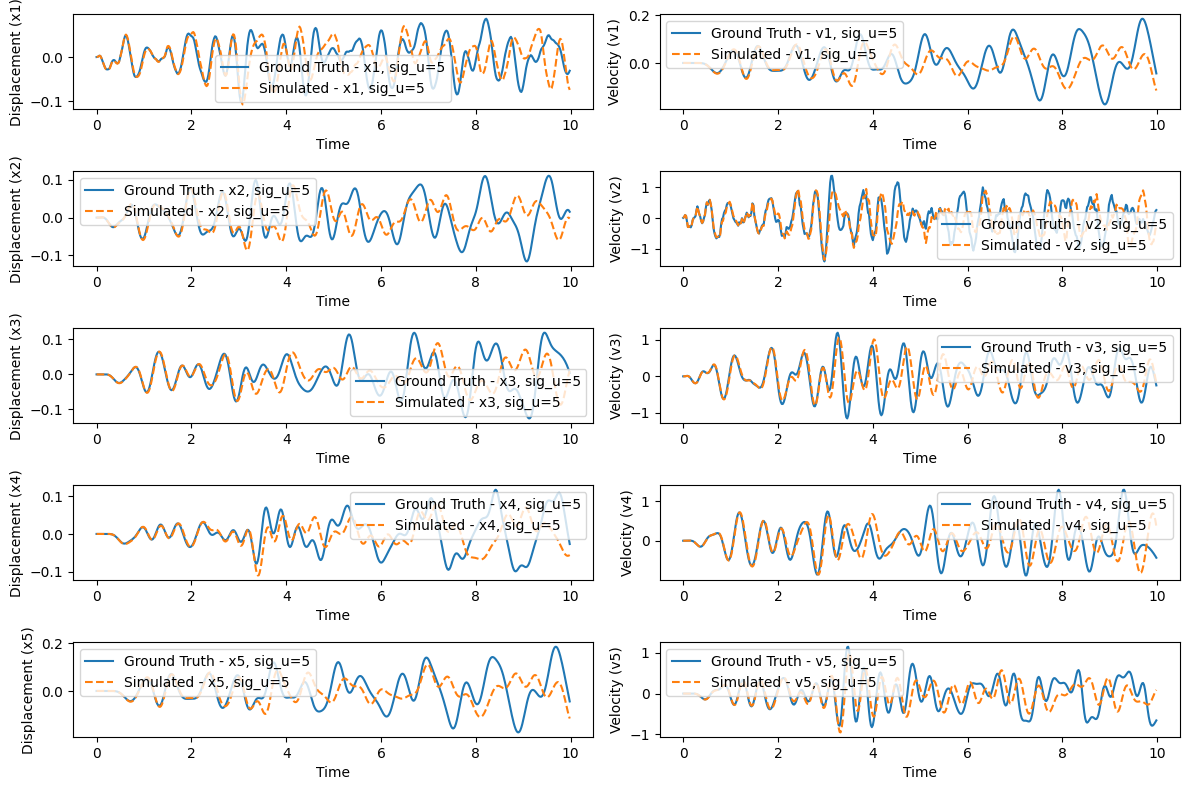

In [9]:
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u)):
    plt.figure(figsize=(12, 8))

    # Plotting for each degree of freedom
    for j in range(ndof):
        plt.subplot(ndof, 2, 2*j+1)  # For displacement (x)
        plt.plot(time_values, data_gt[:, i, j], label=f'Ground Truth - x{ j + 1 }, sig_u={sig_u[i]}')
        plt.plot(time_values, data_simulated[:, i, j], label=f'Simulated - x{ j + 1 }, sig_u={sig_u[i]}', linestyle='dashed')
        plt.xlabel('Time')
        plt.ylabel(f'Displacement (x{ j + 1 })')
        plt.legend()

        plt.subplot(ndof, 2, 2*j+2)  # For velocity (v)
        plt.plot(time_values, data_gt[:, i, j + 4], label=f'Ground Truth - v{ j + 1 }, sig_u={sig_u[i]}')
        plt.plot(time_values, data_simulated[:, i, j + 4], label=f'Simulated - v{ j + 1 }, sig_u={sig_u[i]}', linestyle='dashed')
        plt.xlabel('Time')
        plt.ylabel(f'Velocity (v{ j + 1 })')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [10]:
class DifferentialSolver:
    def __init__(self, model, optimizer, criterion=nn.MSELoss()):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, simulation, target_solution, u, max_epochs=100, msteps=2, batch_size=1000):
        display_at = max(1, max_epochs / 20)
        losses = []
        N = target_solution.shape[0]
        feasible_range = N - msteps - 1
        std_data = torch.std(target_solution, axis = 0).T    #torch.Size([2, 5])

        for sim in range(max_epochs):
            self.optimizer.zero_grad()
            loss = 0

            for batch in range(batch_size):
                r = np.random.randint(feasible_range)
                yi = target_solution[r, :].T # torch.Size([10, 5])

                for m in range(msteps):
                    u_m = u[r + m, :].T # torch.Size([5, 1])
                    yi = simulation.step(yi, u_m)
                    input = torch.cat([u_m[0:1, :], yi], axis=0).T  # Concatenate k and yi.T
                    epsilon = self.model(input).T # torch.Size([2, 5])
                    dy_i = simulation.step_model(epsilon)
                    yi = yi + dy_i
                    loss += self.criterion(yi.div(std_data) , target_solution[r + m + 1, :].T.div(std_data)) / msteps

            loss /= batch_size
            loss.backward(retain_graph=True)
            self.optimizer.step()
            losses.append(loss.item())

            if sim % display_at == 0:
                print(sim, "Training Loss:", loss.item())

        return losses

In [11]:
# Create a neural network model
model = NeuralNet(11, [16, 32, 64, 32, 16], 5, nn.ReLU(), device)

# Create a DifferentialSolver and train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
solver = DifferentialSolver(model, optimizer)

0 Training Loss: 0.000720104668289423
1000 Training Loss: 0.00020180756109766662
2000 Training Loss: 1.4201015801518224e-05
3000 Training Loss: 5.469973530125571e-06
4000 Training Loss: 3.374737843842013e-06
5000 Training Loss: 2.005802116400446e-06
6000 Training Loss: 1.4324617723104893e-06
7000 Training Loss: 1.1130314305773936e-06
8000 Training Loss: 1.173136865872948e-06
9000 Training Loss: 7.49695971080655e-07
10000 Training Loss: 6.470631319643871e-07
11000 Training Loss: 6.65065044813673e-07
12000 Training Loss: 5.028605869483727e-07
13000 Training Loss: 8.244221021413978e-07
14000 Training Loss: 4.709493168775225e-07
15000 Training Loss: 8.402407729590777e-07
16000 Training Loss: 4.827025463782775e-07
17000 Training Loss: 5.209830646890623e-07
18000 Training Loss: 4.0279857671521313e-07
19000 Training Loss: 4.0952232893687324e-07


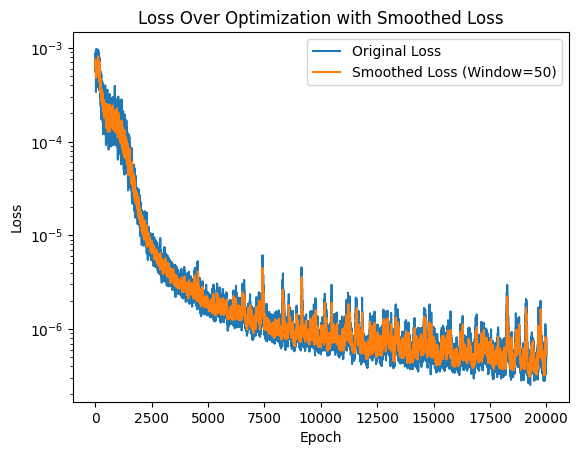

In [12]:
losses = solver.train(simulator, target_solution=data_gt, u = u_data, max_epochs=20000, msteps=1, batch_size=100)
plot_losses(losses, 5)

In [14]:
data_simulated_NN = torch.zeros(nt, len(sig_u), 10)
yi = data_simulated_NN[0, :].T

for m in range(nt - 1):
    u_m = u_data[m , :].T # torch.Size([1, 5])
    yi = simulator.step(yi, u_m)
    input = torch.cat([u_m[0:1, :], yi], axis=0).T  # Concatenate k and yi.T
    epsilon = solver.model(input).T # torch.Size([2, 5])
    dy_i = simulator.step_model(epsilon)
    yi = yi + dy_i
    data_simulated_NN[m + 1, :] = yi.T

final_error = torch.mean((data_gt -data_simulated_NN) ** 2)
final_error

tensor(3.7255e-05, grad_fn=<MeanBackward0>)

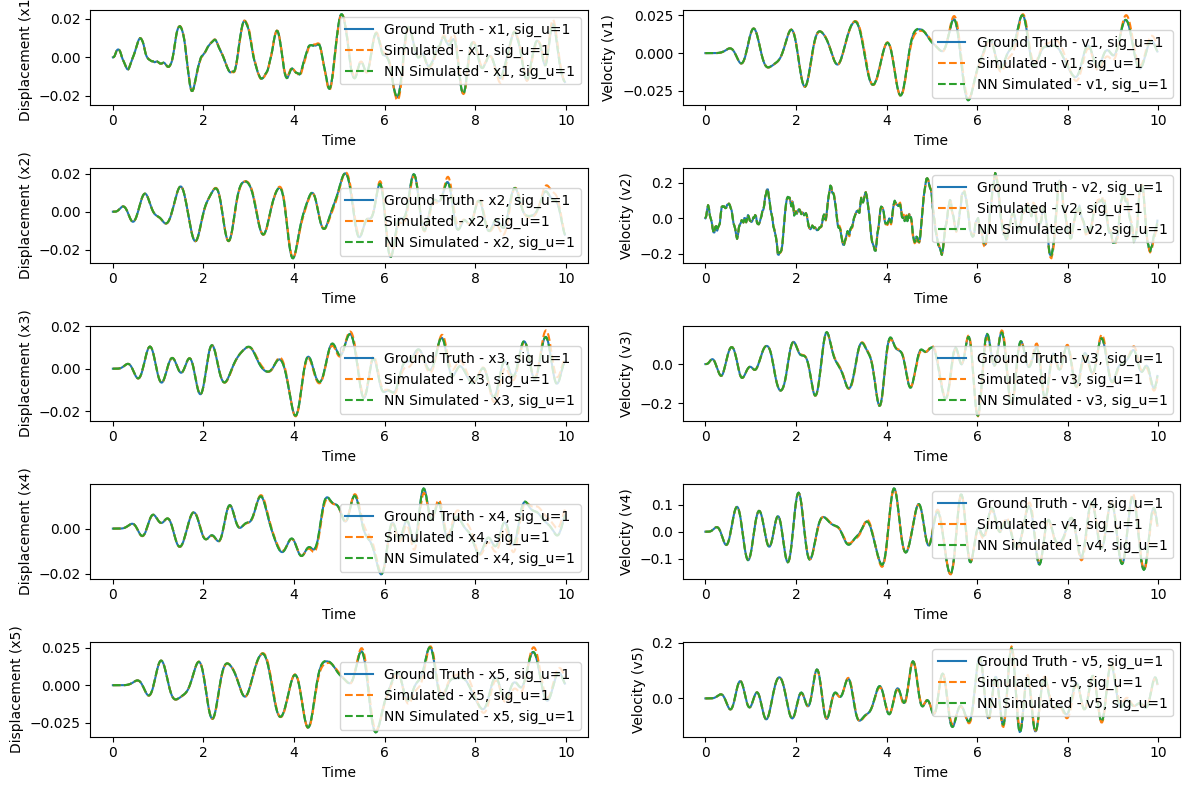

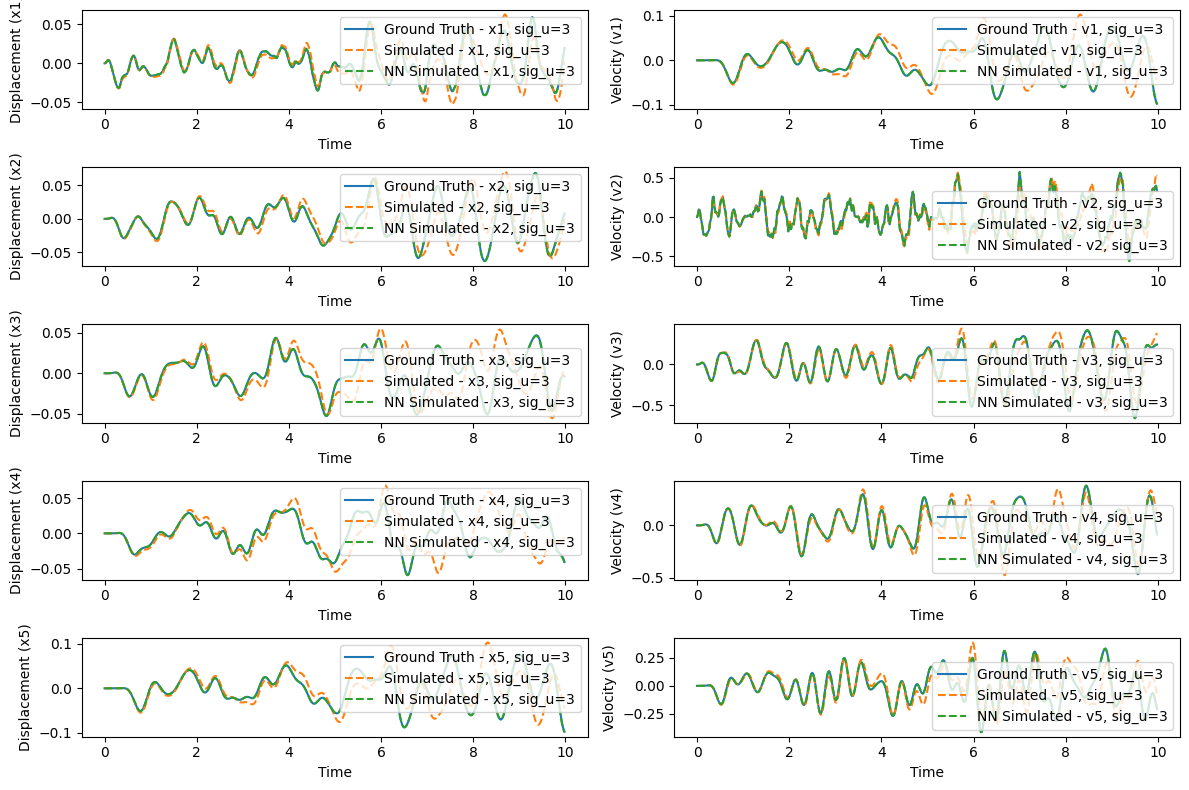

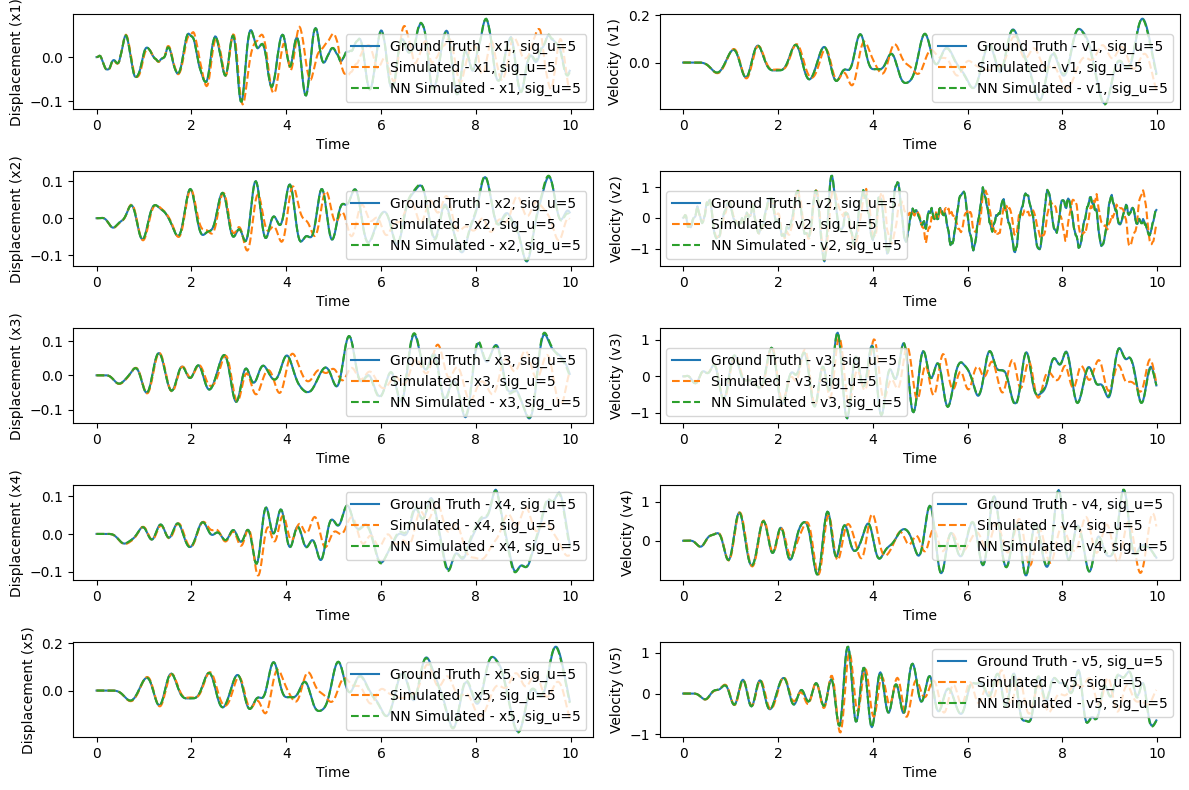

In [15]:
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u)):
    plt.figure(figsize=(12, 8))

    # Plotting for each degree of freedom
    for j in range(ndof):
        plt.subplot(ndof, 2, 2*j+1)  # For displacement (x)
        plt.plot(time_values, data_gt[:, i, j], label=f'Ground Truth - x{ j + 1 }, sig_u={sig_u[i]}')
        plt.plot(time_values, data_simulated[:, i, j], label=f'Simulated - x{ j + 1 }, sig_u={sig_u[i]}', linestyle='dashed')
        plt.plot(time_values, data_simulated_NN.detach().numpy()[:, i, j], label=f'NN Simulated - x{ j + 1 }, sig_u={sig_u[i]}', linestyle='dashed')
        plt.xlabel('Time')
        plt.ylabel(f'Displacement (x{ j + 1 })')
        plt.legend()

        plt.subplot(ndof, 2, 2*j+2)  # For velocity (v)
        plt.plot(time_values, data_gt[:, i, j + 4], label=f'Ground Truth - v{ j + 1 }, sig_u={sig_u[i]}')
        plt.plot(time_values, data_simulated[:, i, j + 4], label=f'Simulated - v{ j + 1 }, sig_u={sig_u[i]}', linestyle='dashed')
        plt.plot(time_values, data_simulated_NN.detach().numpy()[:, i, j + 4], label=f'NN Simulated - v{ j + 1 }, sig_u={sig_u[i]}', linestyle='dashed')
        plt.xlabel('Time')
        plt.ylabel(f'Velocity (v{ j + 1 })')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [16]:
sig_u_test = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.4, 6, 6.5, 7]
data_gt_test = torch.zeros(nt, len(sig_u_test), 10)
data_simulated_test = torch.zeros(nt, len(sig_u_test), 10)
data_simulated_NN_test = torch.zeros(nt, len(sig_u_test), 10)
u_data_test = torch.zeros(nt, len(sig_u_test), 5)

for i in range(len(sig_u_test)):
    u = generate_u(sig_u_test[i], nt, fs, device)
    u_vec = torch.zeros(nt, 5).to(device)
    u_vec[:, 0] = u
    data_gt_test[:, i, :] = generate_date(spring_model_gt, u_vec).T
    data_simulated_test[:, i, :] = generate_date(simulator, u_vec).T
    u_data_test[:, i, :] = u_vec


yi = data_simulated_NN_test[0, :].T
for m in range(nt - 1):
    u_m = u_data_test[m , :].T # torch.Size([1, 5])
    yi = simulator.step(yi, u_m)
    input = torch.cat([u_m[0:1, :], yi], axis=0).T  # Concatenate k and yi.T
    epsilon = solver.model(input).T # torch.Size([2, 5])
    dy_i = simulator.step_model(epsilon)
    yi = yi + dy_i
    data_simulated_NN_test[m + 1, :] = yi.T

In [17]:
initial_error_test = torch.mean((data_gt_test -data_simulated_test) ** 2)
final_error_test = torch.mean((data_gt_test -data_simulated_NN_test) ** 2)
initial_error_test, final_error_test

(tensor(0.0213), tensor(0.0015, grad_fn=<MeanBackward0>))

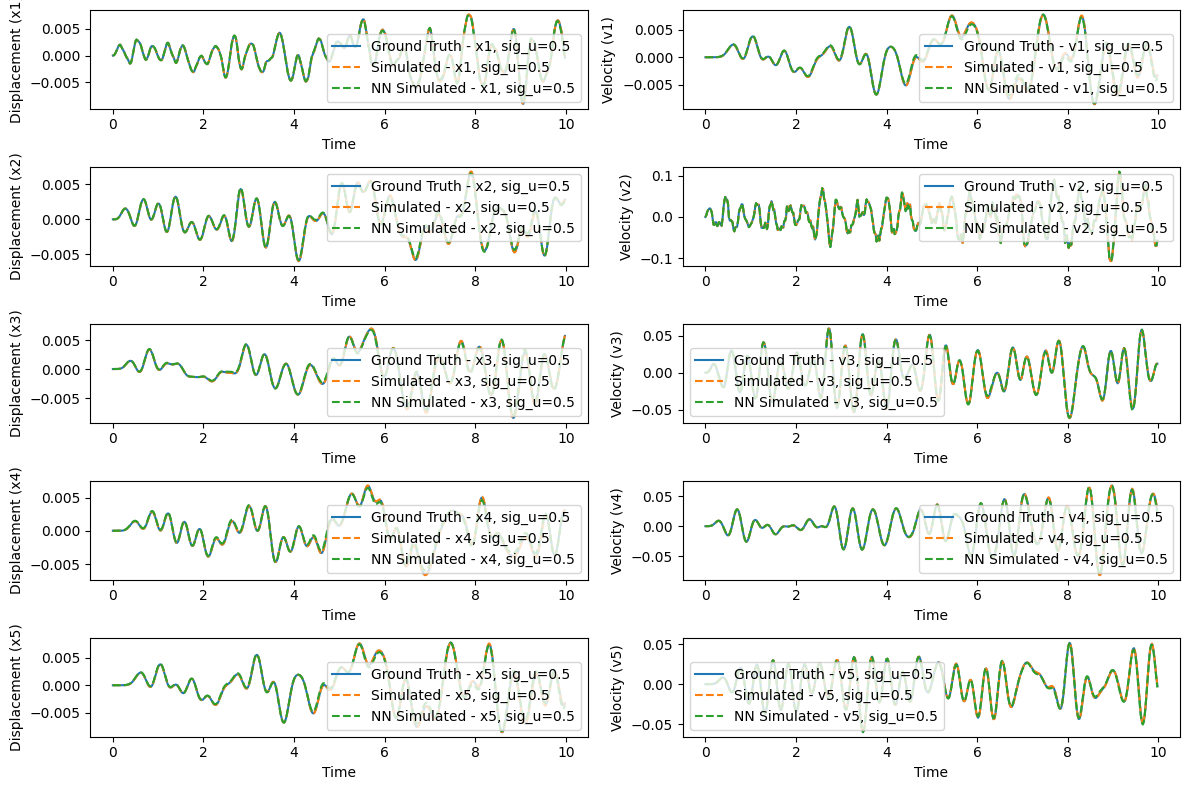

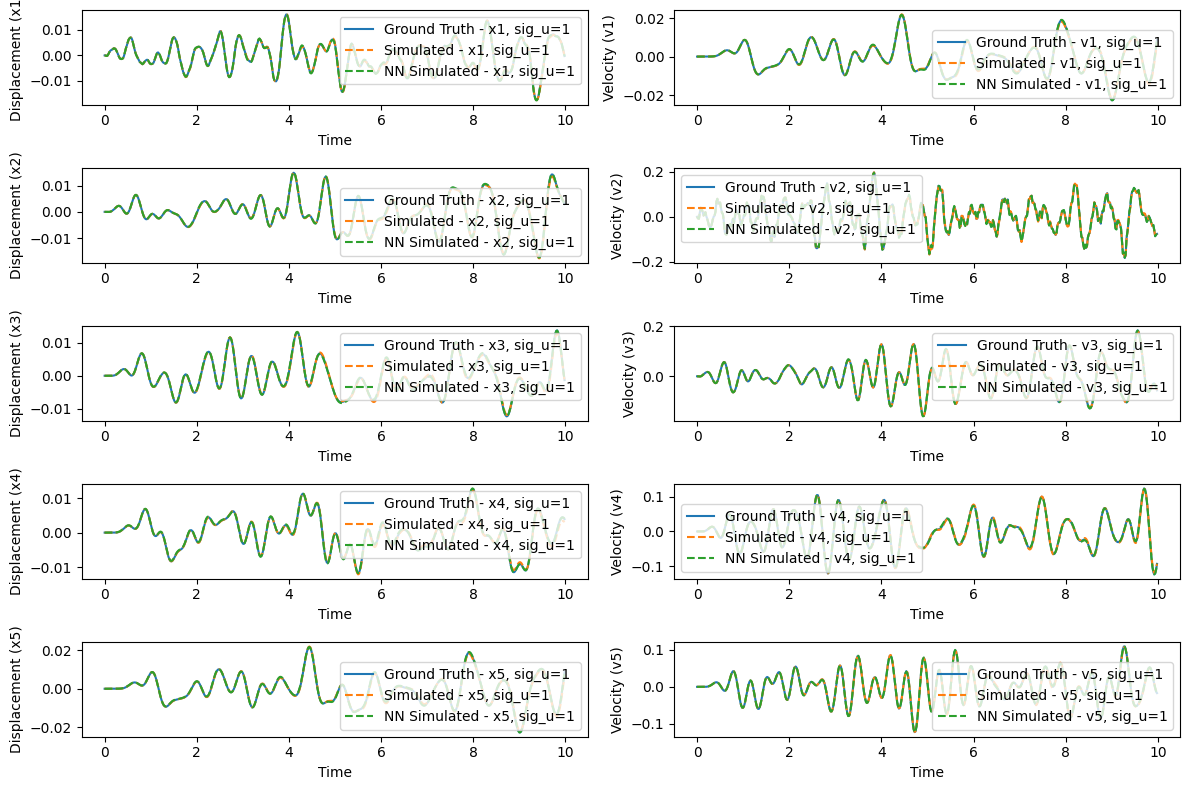

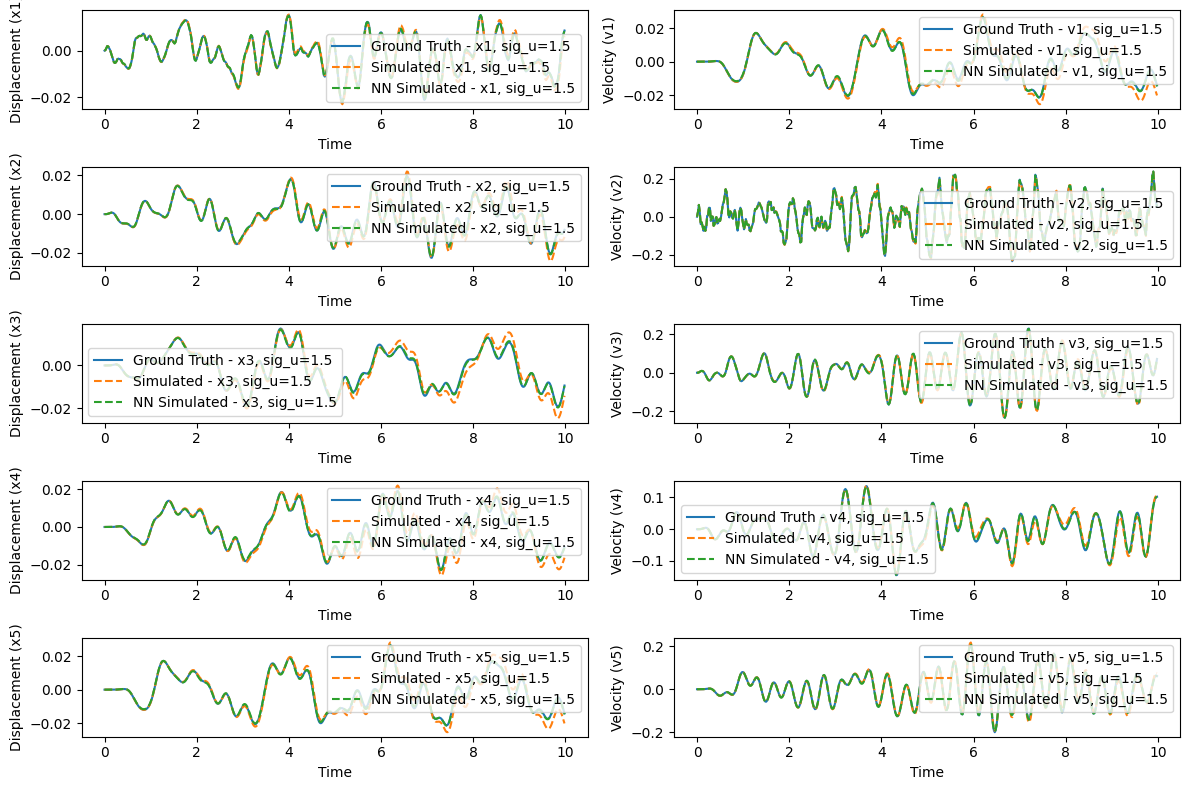

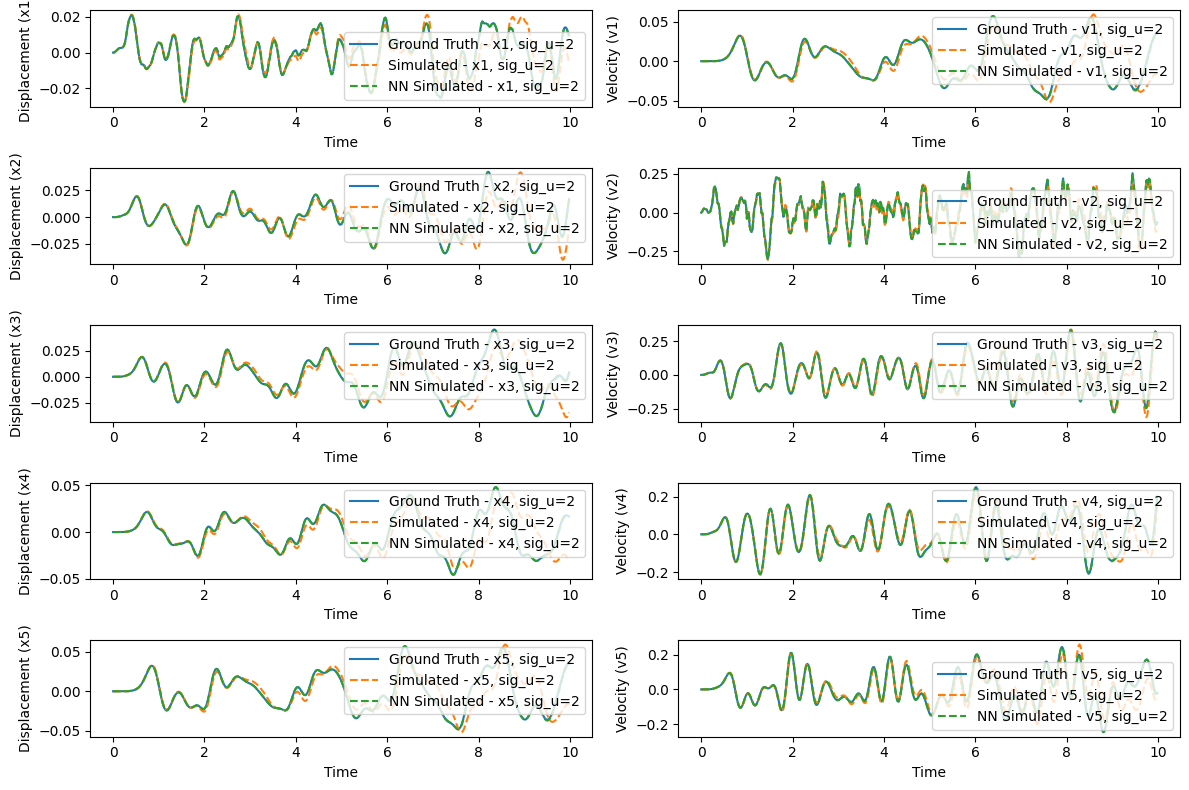

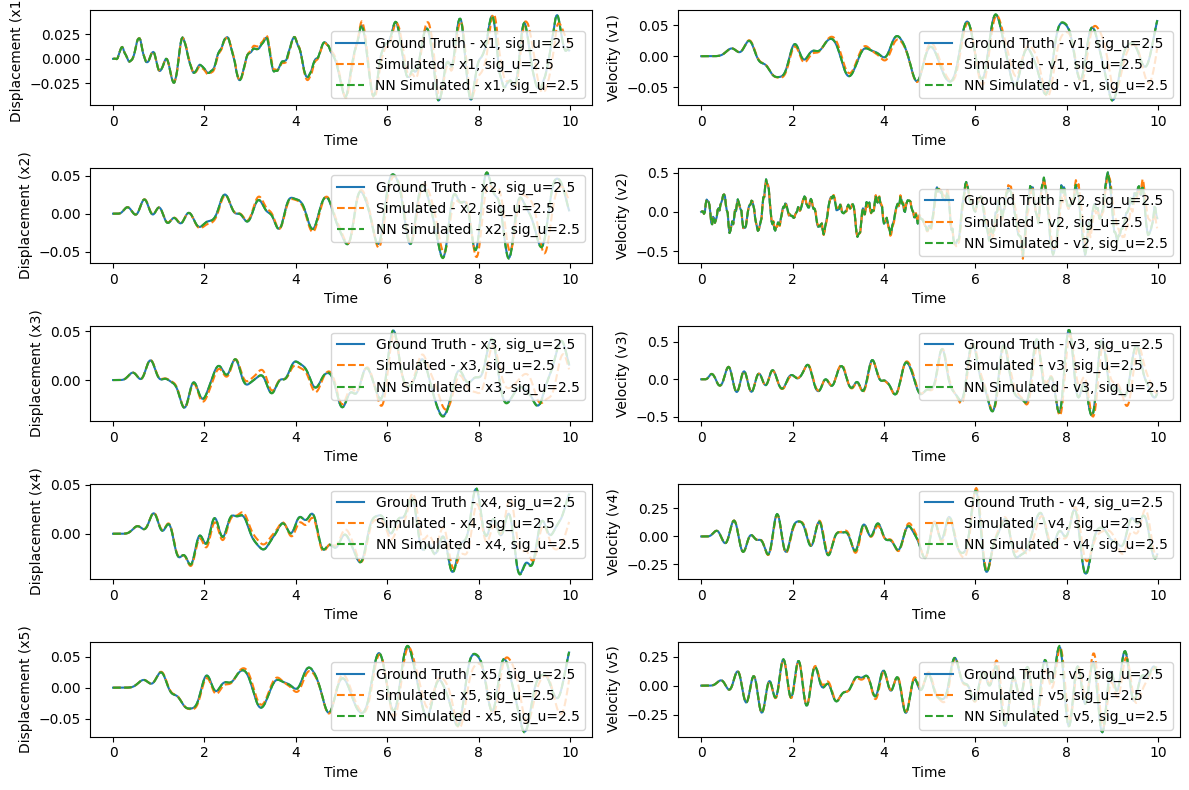

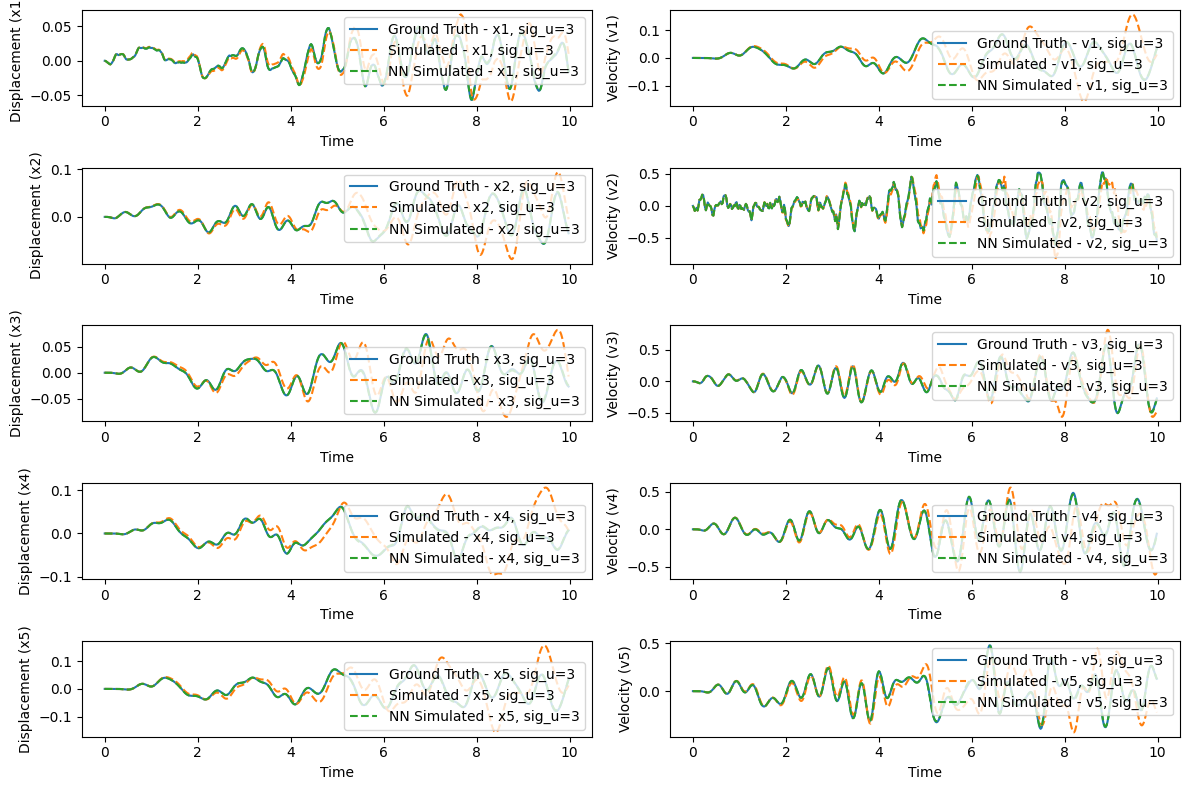

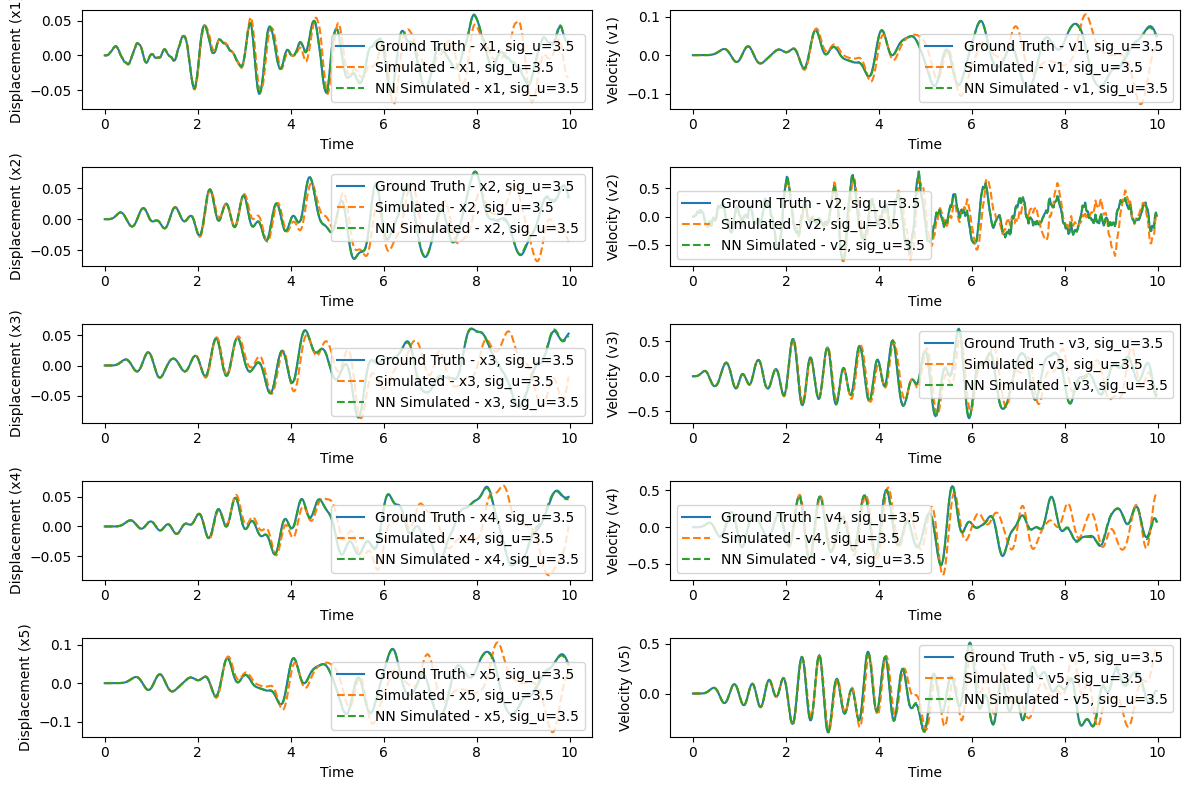

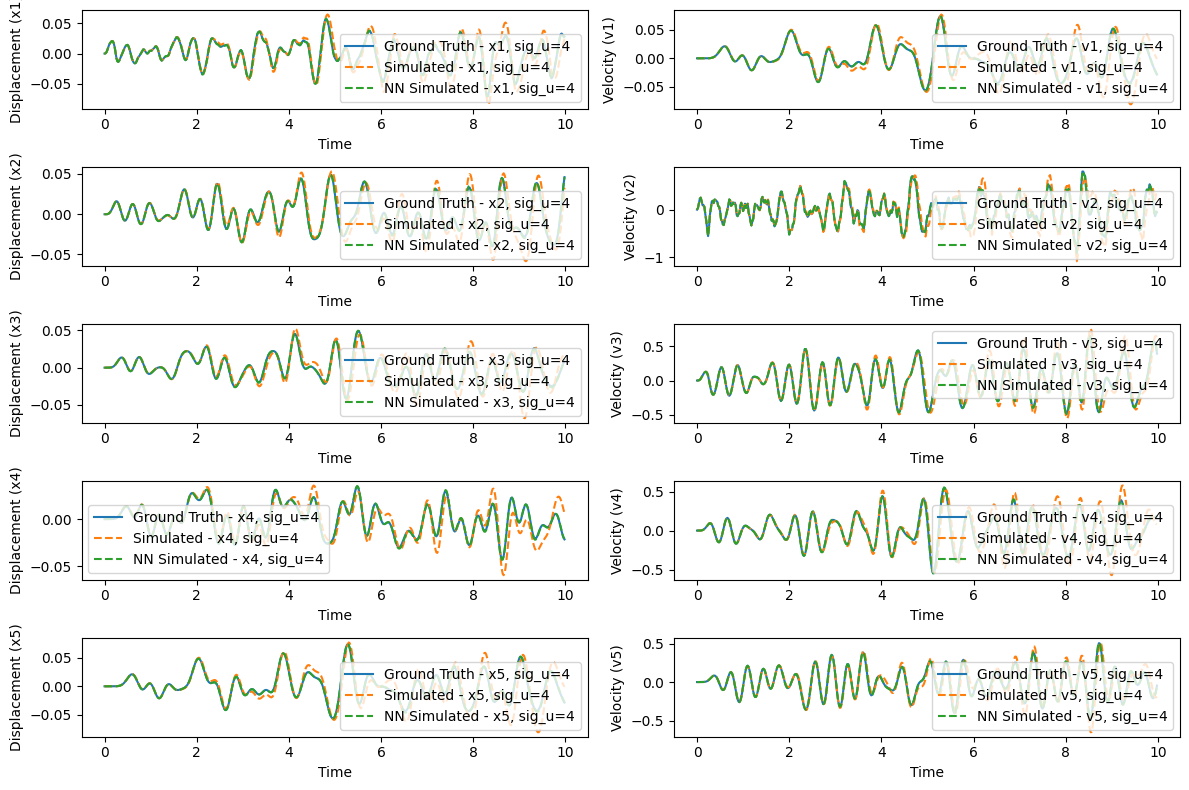

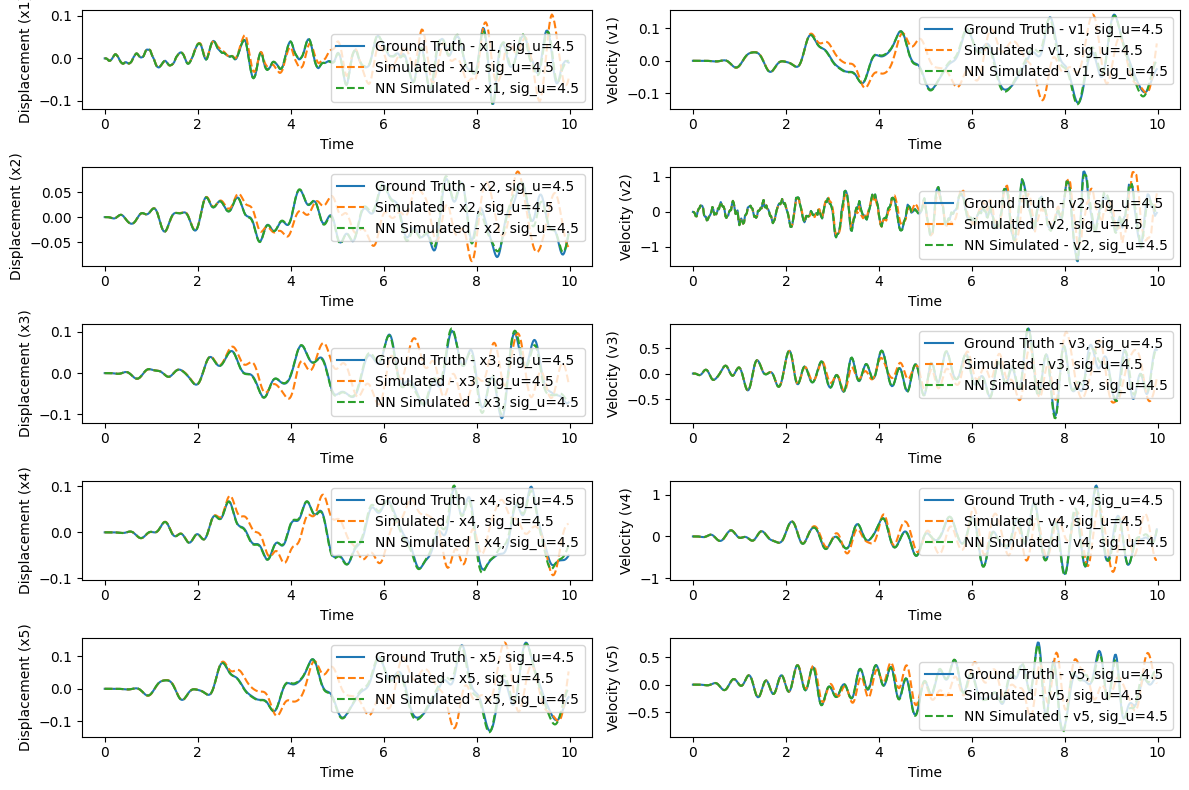

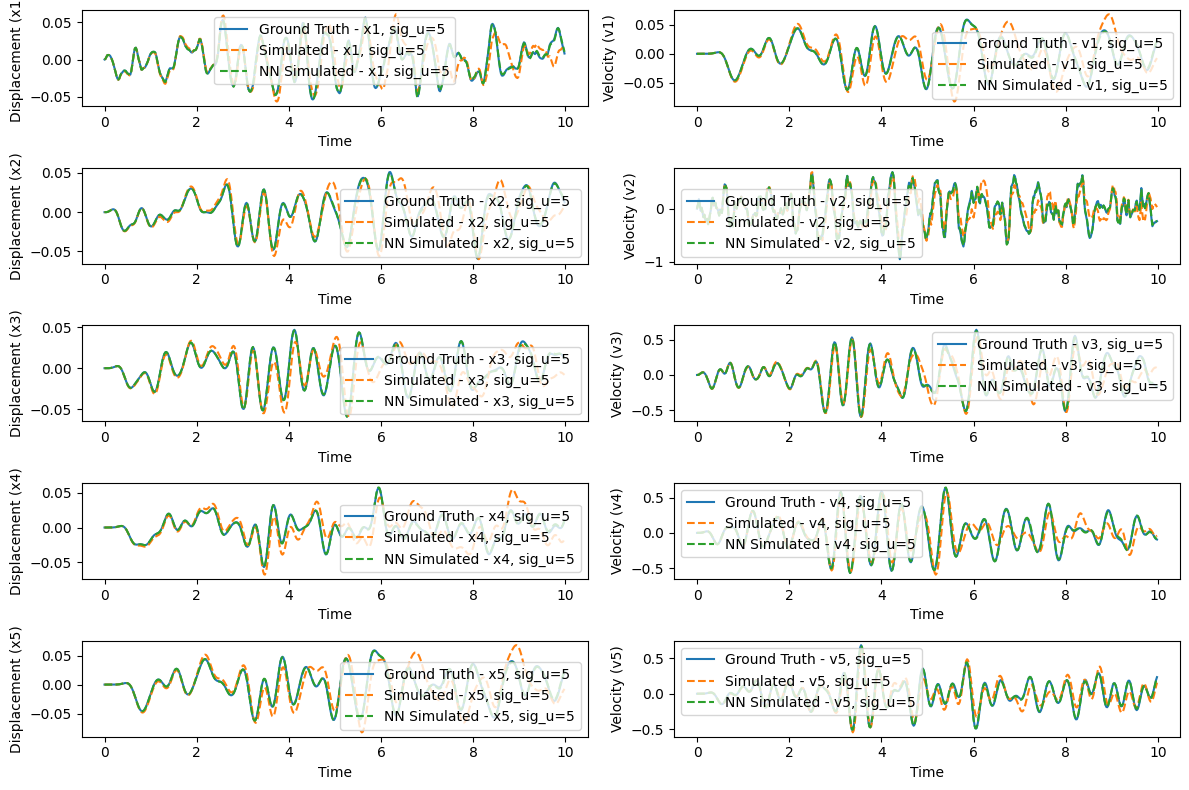

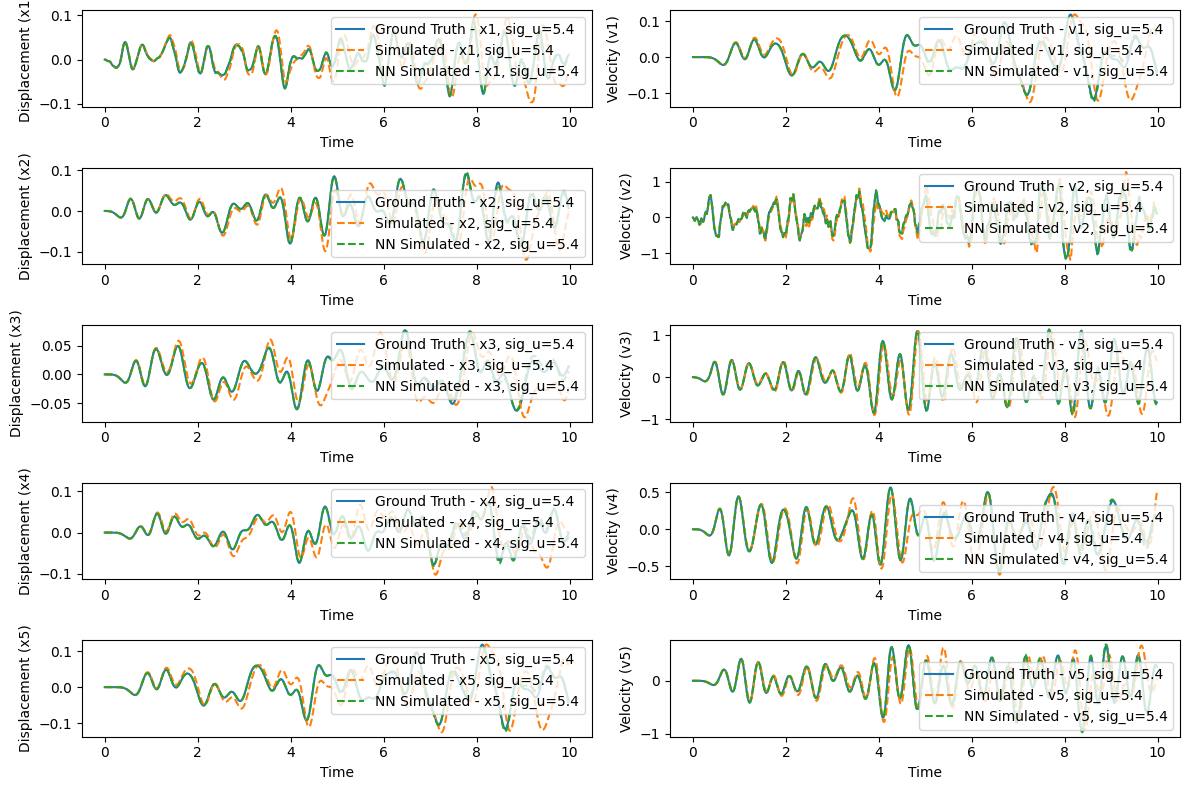

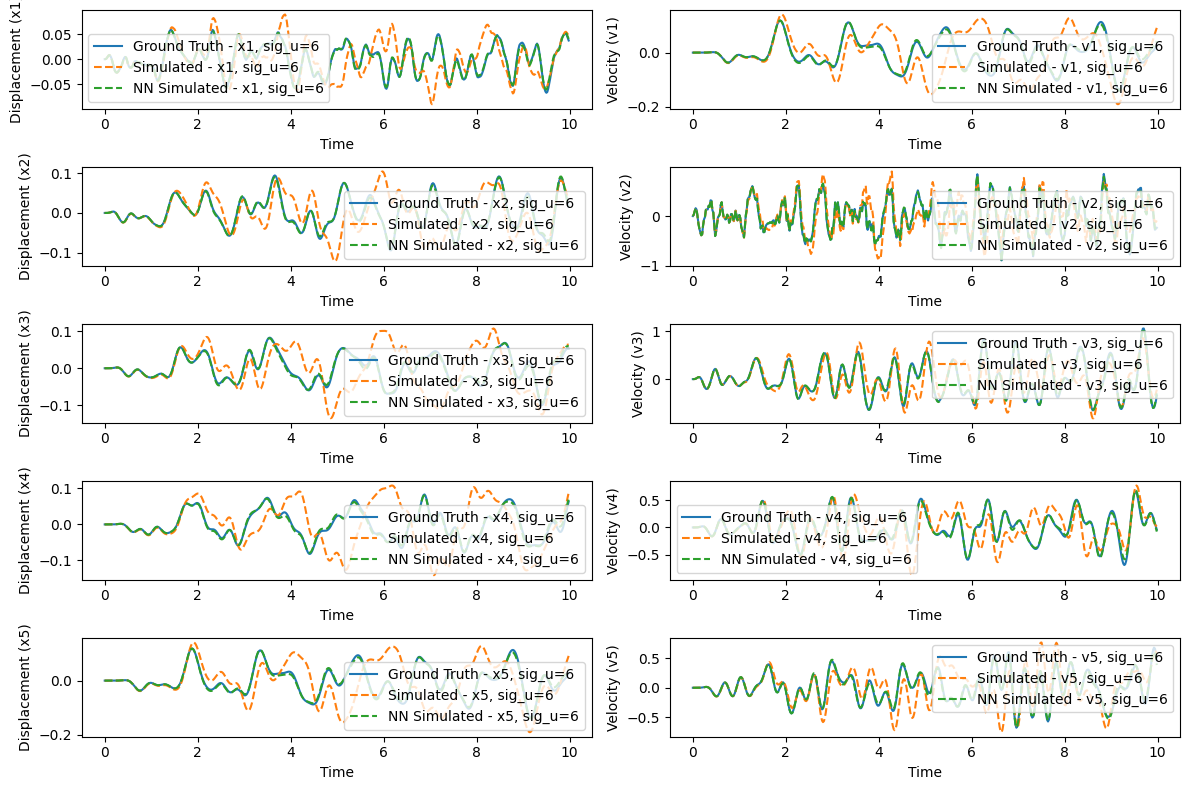

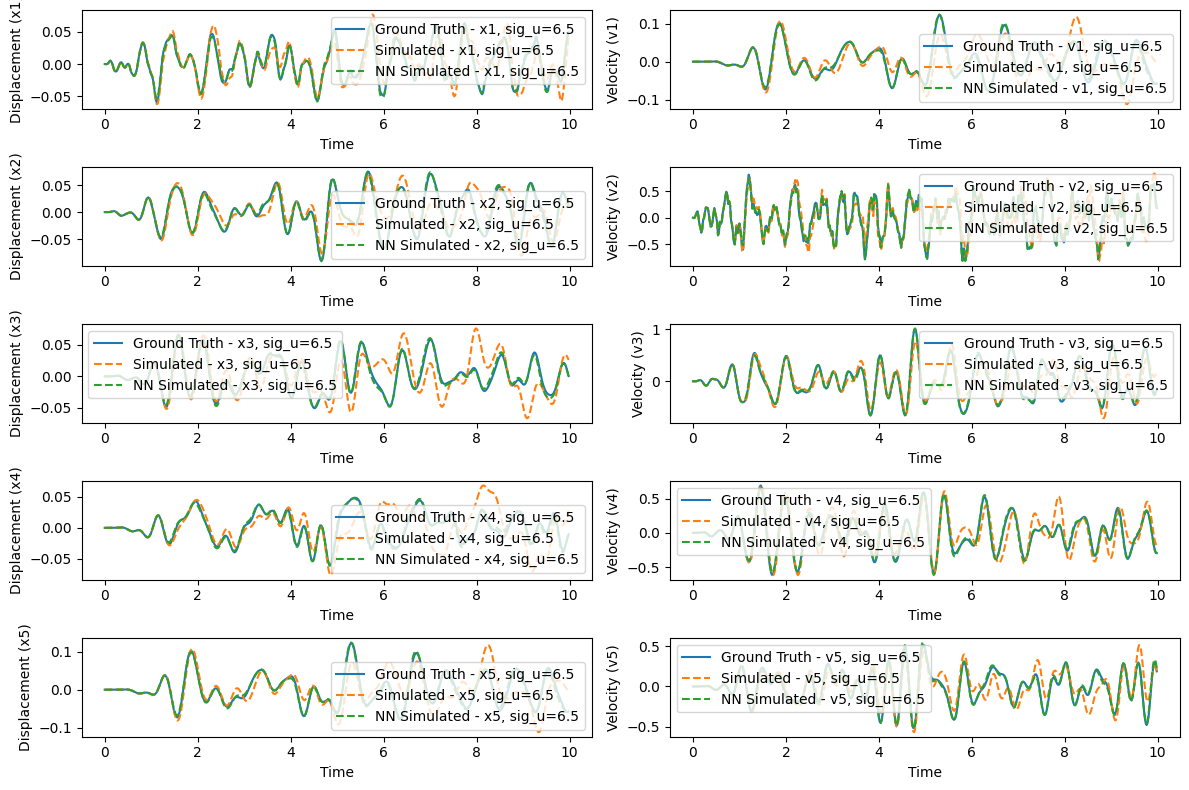

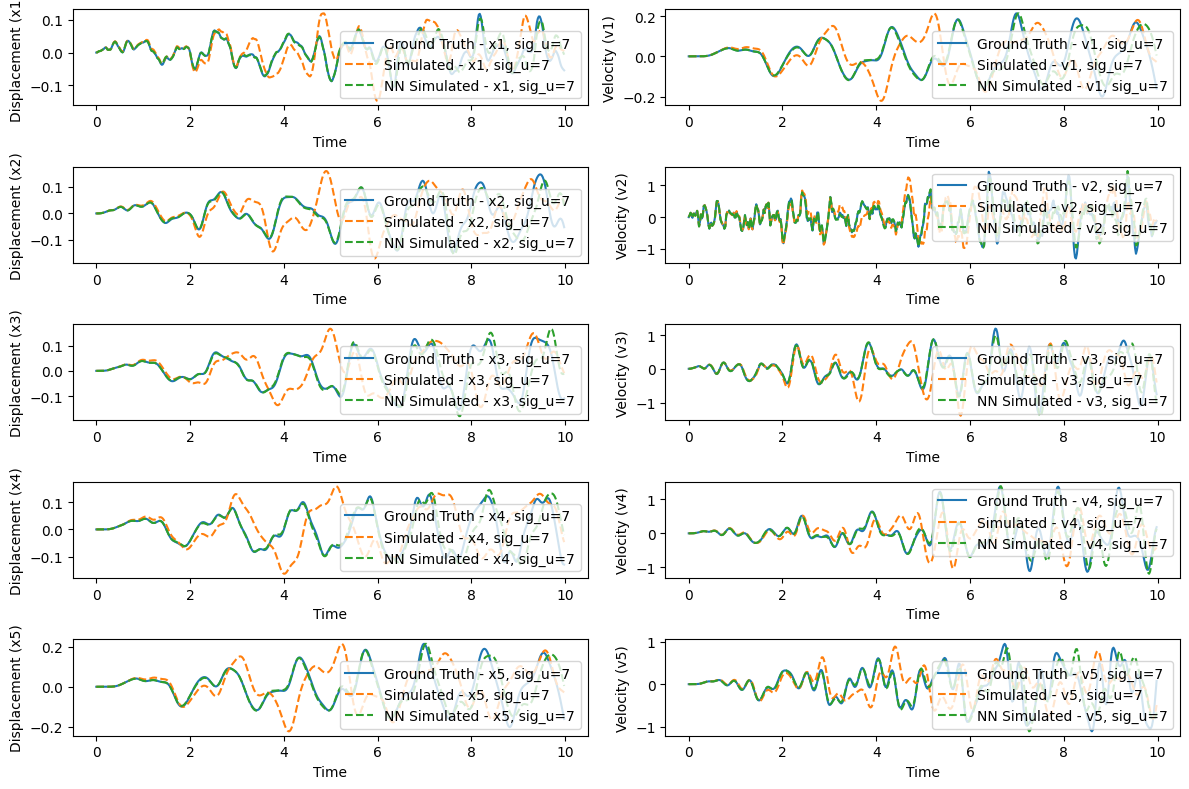

In [18]:
time_values = tspan.squeeze().cpu().numpy()

for i in range(len(sig_u_test)):
    plt.figure(figsize=(12, 8))

    # Plotting for each degree of freedom
    for j in range(ndof):
        plt.subplot(ndof, 2, 2*j+1)  # For displacement (x)
        plt.plot(time_values, data_gt_test[:, i, j], label=f'Ground Truth - x{ j + 1 }, sig_u={sig_u_test[i]}')
        plt.plot(time_values, data_simulated_test[:, i, j], label=f'Simulated - x{ j + 1 }, sig_u={sig_u_test[i]}', linestyle='dashed')
        plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, j], label=f'NN Simulated - x{ j + 1 }, sig_u={sig_u_test[i]}', linestyle='dashed')
        plt.xlabel('Time')
        plt.ylabel(f'Displacement (x{ j + 1 })')
        plt.legend()

        plt.subplot(ndof, 2, 2*j+2)  # For velocity (v)
        plt.plot(time_values, data_gt_test[:, i, j + 4], label=f'Ground Truth - v{ j + 1 }, sig_u={sig_u_test[i]}')
        plt.plot(time_values, data_simulated_test[:, i, j + 4], label=f'Simulated - v{ j + 1 }, sig_u={sig_u_test[i]}', linestyle='dashed')
        plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, j + 4], label=f'NN Simulated - v{ j + 1 }, sig_u={sig_u_test[i]}', linestyle='dashed')
        plt.xlabel('Time')
        plt.ylabel(f'Velocity (v{ j + 1 })')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [53]:
# Save the parameters of the model
torch.save(model.state_dict(), 'linear_5_dof_new_model_parameters_m1.pth')